In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import re
from liftover import get_lifter
import seaborn as sns
import networkx as nx
import pickle
sys.path.append("/home/yanhu/DddA/DddA/tdac_seq")
from ddda_dataset import *
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
# Create a folder to save plots
working_dir = "/home/yanhu/data/DddA/HJR235/"
plot_dir = os.path.join("/home/yanhu/data/DddA/HJR235/", "plots")
os.system("mkdir -p " + plot_dir)

# Create a dictionary for reference regions
ref_range_dict = {
    'HJR235': ('chr7', 27158522, 27163197)
}

# Initialize ddda_dataset
ddda_data = ddda_dataset(
    ID = "HJR_235", 
    region_dict = ref_range_dict, 
    genome_file = "/home/yanhu/data/DddA/shared/refGenomes/hg38.fa", 
    fastq_file = "/home/yanhu/data/DddA/HJR235/HJR235_4.fastq", 
    working_dir = "/home/yanhu/data/DddA/HJR235/"
)

# Load DddA bias model
with open("/home/yanhu/data/DddA/HJR245/bias_dict.pkl", "rb") as f:
    ddda_data.bias_model = pickle.load(f)

# Align reads
gap_threshold = 500
ddda_data.align_reads(
    start_gap_threshold = gap_threshold,
    end_gap_threshold = gap_threshold
)

# Position of the CTCF motif
motif_start, motif_end = 2623, 2645

Loading reference genome
Extracting sequences for each locus
Computing sequence bias


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 162206/162206 [00:50<00:00, 3241.89it/s]


122522 reads aligned. 39684 reads unaligned


In [3]:
# Align reads
gap_threshold = 500
ddda_data.align_reads(
    start_gap_threshold = gap_threshold,
    end_gap_threshold = gap_threshold
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 162206/162206 [00:49<00:00, 3260.46it/s]


122522 reads aligned. 39684 reads unaligned


In [4]:
# Position of the cutsite(CTCF motif)
motif_start, motif_end = 2623, 2645 

In [5]:
locus = "HJR235"

# Find reads where the sgRNA target site is covered by a deletion
del_start, del_end = motif_start, motif_end
del_matrix = ddda_data.del_dict[locus]
motif_del = np.array(np.max(del_matrix[:, del_start:del_end], axis=1).todense())[:, 0]
del_read_inds = np.where(motif_del == 1)[0]

# Only keep reads where positions outside of the vicinity of the sgRNA target site are not deleted
upstream_del = np.array(np.max(del_matrix[:, :del_start], axis=1).todense())[:, 0]
downstream_del = np.array(np.max(del_matrix[:, del_end:], axis=1).todense())[:, 0]
upstream_filter = upstream_del == 0
downstream_filter = downstream_del == 0
filter = np.where(upstream_filter & downstream_filter)[0]
del_read_inds = np.intersect1d(del_read_inds, filter)

# Separately, also find reads without any deletion as a control
undel_read_inds = np.where(np.array(np.max(del_matrix, axis=1).todense())[:, 0] == 0)[0]

In [6]:
# Down-sample the number of reads
min_num = min(len(del_read_inds), len(undel_read_inds),10000)
del_read_inds = np.random.choice(del_read_inds, min_num, replace=False)
undel_read_inds = np.random.choice(undel_read_inds, min_num, replace=False)

In [7]:
# De-duplicate reads
del_read_ids = ddda_data.dedup_reads(
    locus = locus, 
    read_ids = np.array(ddda_data.read_ids[locus])[del_read_inds]
)
undel_read_ids = ddda_data.dedup_reads(
    locus = locus, 
    read_ids = np.array(ddda_data.read_ids[locus])[undel_read_inds]
    
)
del_read_inds = np.array([ddda_data.read_ids[locus].index(i) for i in del_read_ids])
undel_read_inds = np.array([ddda_data.read_ids[locus].index(i) for i in undel_read_ids])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2618/2618 [00:00<00:00, 5754.08it/s]
2618it [00:00, 1201782.63it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2618/2618 [00:00<00:00, 5763.96it/s]
2618it [00:00, 1303655.21it/s]


In [8]:
# Combine deleted and undeleted reads 
selected_read_inds = np.concatenate([del_read_inds, undel_read_inds])
selected_reads = np.array(ddda_data.read_ids[locus])[selected_read_inds]
selected_del_flags = np.concatenate([np.ones(len(del_read_inds)), np.zeros(len(undel_read_inds))])
selection_dict = {"HJR235":selected_reads}

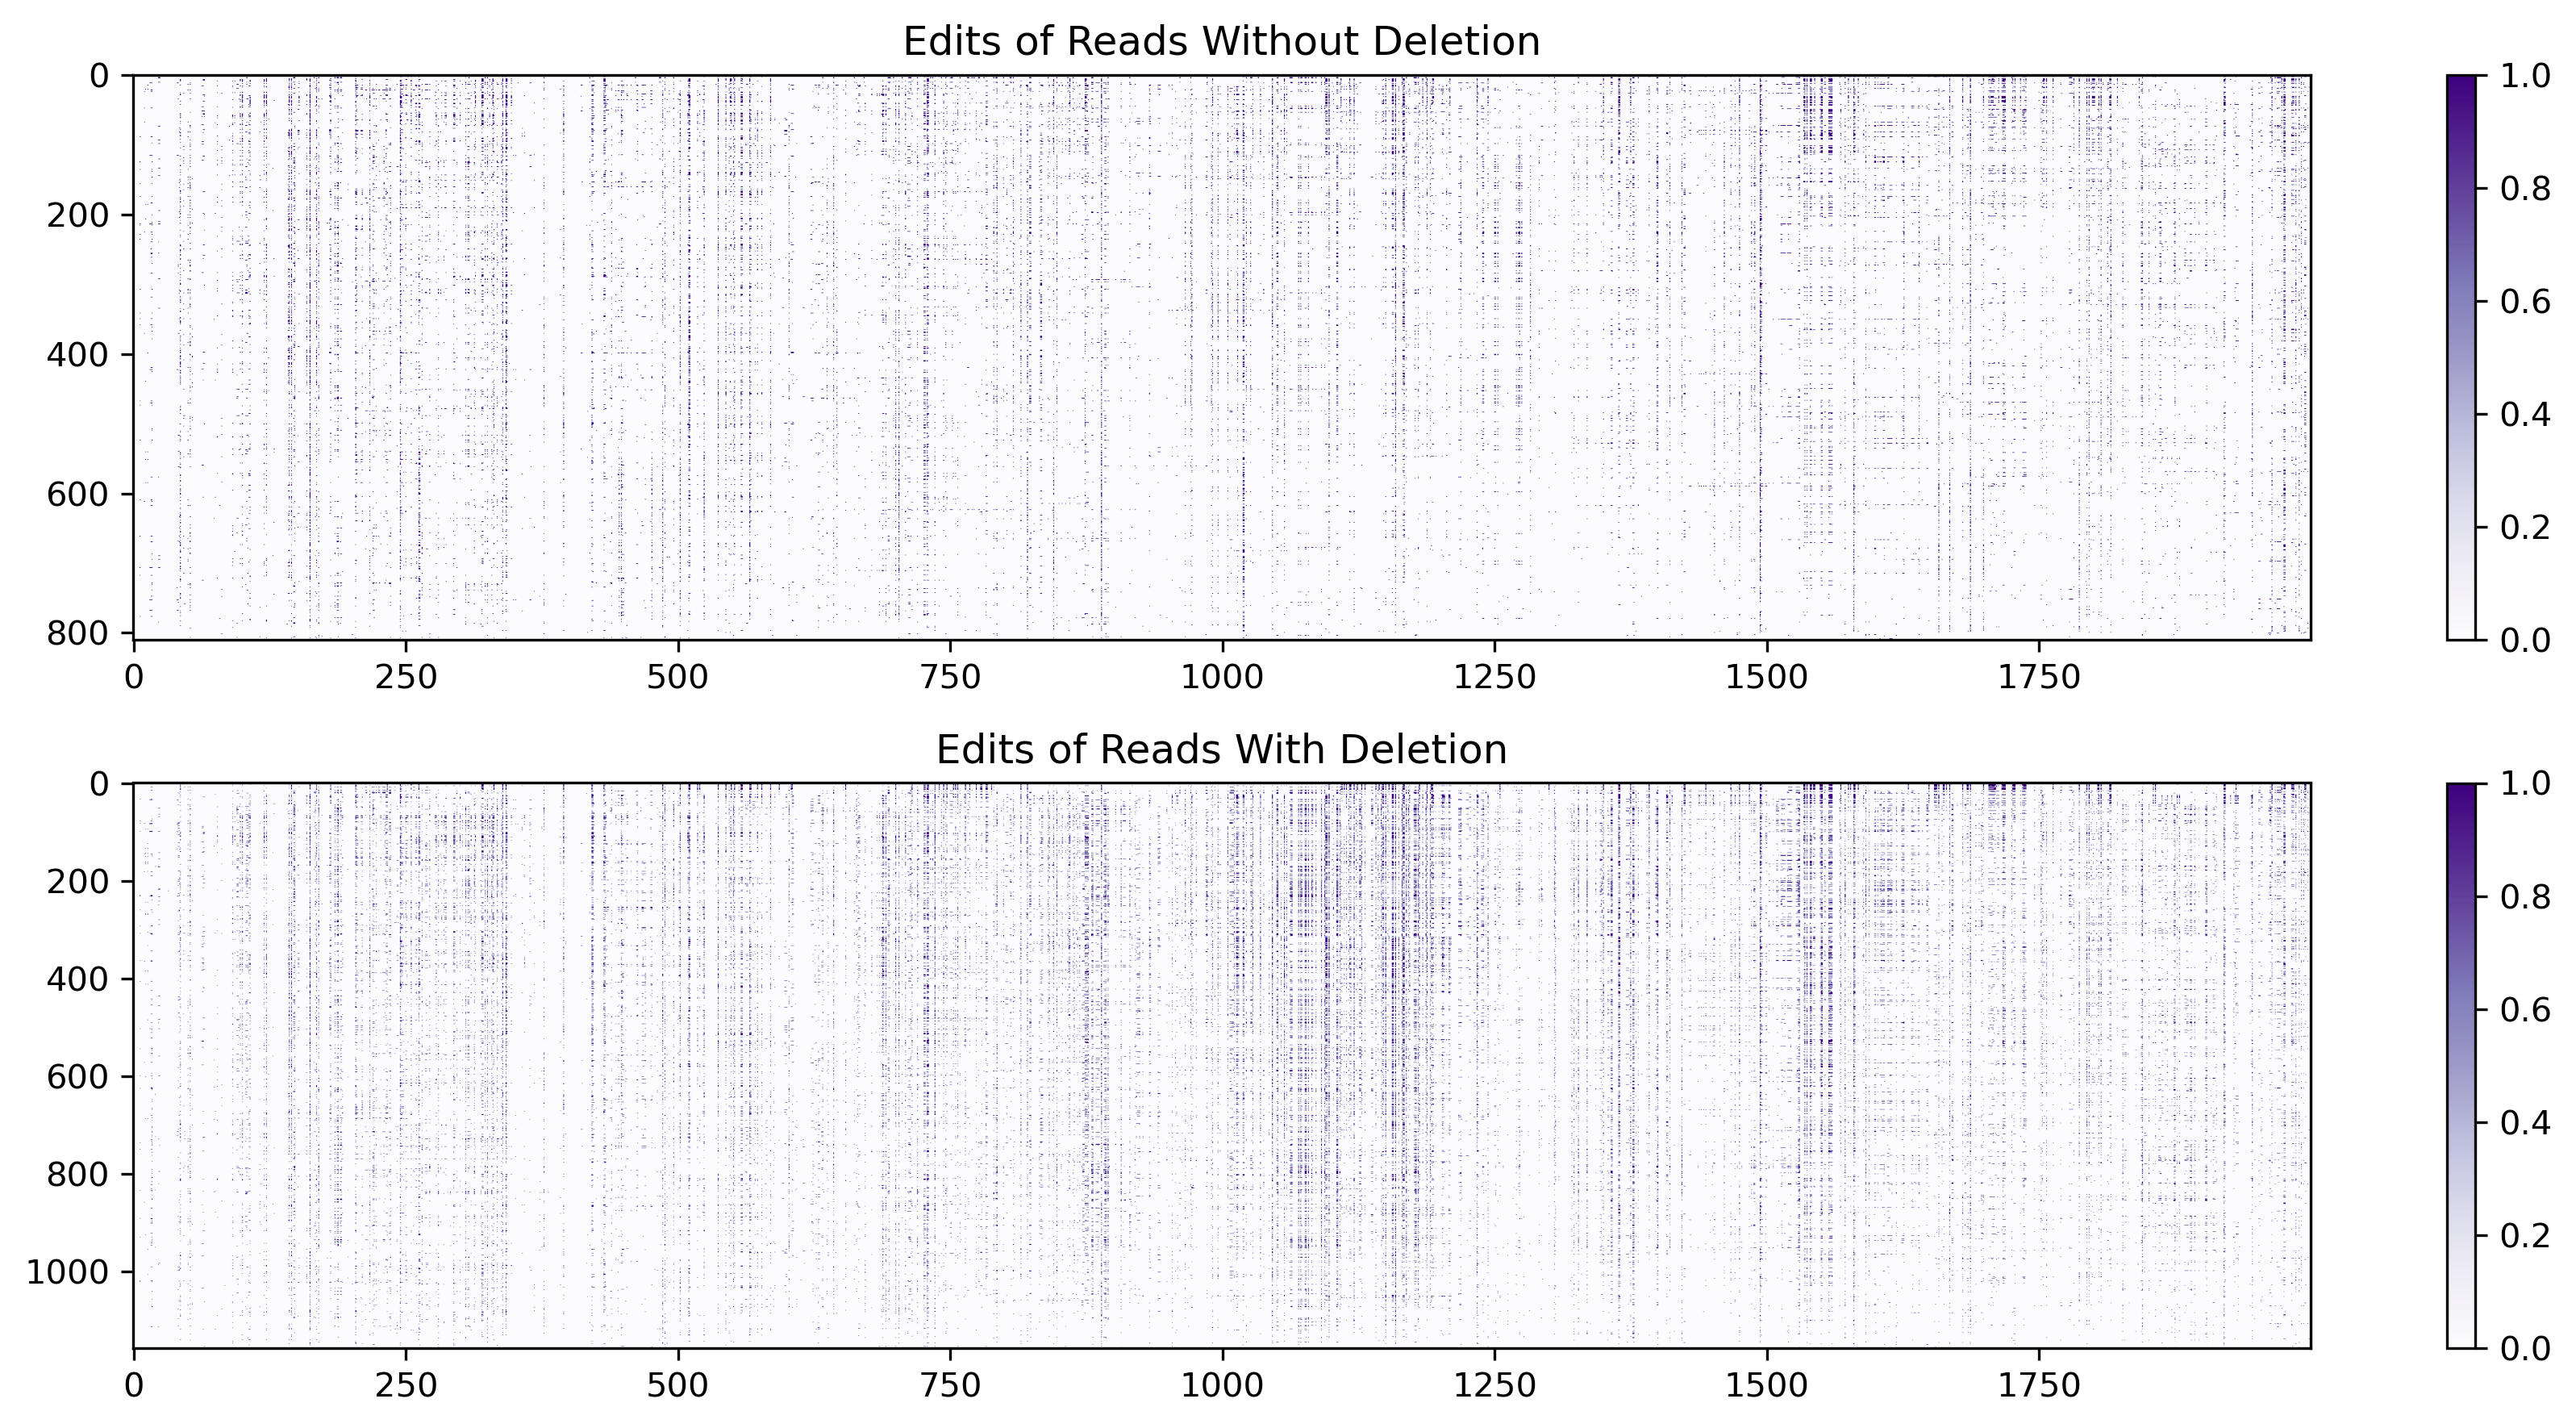

In [9]:
edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())
read_edit_num = np.sum(edits, axis=1)
plot_range = np.arange(1500, 3500)
fig, axes = plt.subplots(2, 1, dpi=300, figsize=(12, 6))

# Plot edits of reads without deletion
del_filter = np.where(selected_del_flags == 1)[0]
row_order = [i for i in np.argsort(-read_edit_num) if i in del_filter]

# Use imshow for the heatmap-style plot
im = axes[0].imshow(edits[row_order, :][:, plot_range], aspect='auto', cmap="Purples", vmin=0, vmax=1)
axes[0].set_title("Edits of Reads Without Deletion")
fig.colorbar(im, ax=axes[0])  # Add a colorbar

# Plot edits of reads with deletion
undel_filter = np.where(selected_del_flags == 0)[0]
row_order = [i for i in np.argsort(-read_edit_num) if i in undel_filter]

# Use imshow for the heatmap-style plot
im = axes[1].imshow(edits[row_order, :][:, plot_range], aspect='auto', cmap="Purples", vmin=0, vmax=1)
axes[1].set_title("Edits of Reads With Deletion")
fig.colorbar(im, ax=axes[1])  # Add a colorbar

# Save the figure
plt.tight_layout()
#plt.savefig(os.path.join(plot_dir, "single_read_edits.pdf"))

In [10]:
# Calculate nucleosome footprints for individual reads
footprints_dict = ddda_data.get_footprints(
    selection_dict, 
    footprint_radii = [73], 
    combine_sides="max_pval")

# Convert to -log10 pval
fp_nuc = np.squeeze(np.array([i for i in footprints_dict[locus].values()]))
fp_nuc = -np.log10(fp_nuc)

Computing footprints for HJR235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1968/1968 [00:08<00:00, 243.31it/s]


In [11]:
# Calculate nucleosome footprints for individual reads
footprints_dict = ddda_data.get_footprints(
    selection_dict, 
    footprint_radii = [25], 
    combine_sides="max_pval")

# Convert to -log10 pval
fp_tf = np.squeeze(np.array([i for i in footprints_dict[locus].values()]))
fp_tf = -np.log10(fp_tf)

Computing footprints for HJR235


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1968/1968 [00:05<00:00, 330.16it/s]


In [12]:
# CTCF sgRNA barplot
CTCF_x_values = np.arange(ref_range_dict[locus][1], ref_range_dict[locus][2]+1)
CTCF_values = np.zeros_like(CTCF_x_values)
CTCF_values[(CTCF_x_values >= 27161134) & (CTCF_x_values < 27161153)] = 3  # Adjust indices as needed
CTCF_values_region=CTCF_values[plot_range]
CTCF_x_values_region=CTCF_x_values[plot_range]

# YY1 sgRNA barplot
YY1_x_values = np.arange(ref_range_dict[locus][1], ref_range_dict[locus][2]+1)
YY1_values = np.zeros_like(CTCF_x_values)
YY1_values[(YY1_x_values >= 27161148) & (YY1_x_values < 27161161)] = 3  # Adjust indices as needed
YY1_values_region=YY1_values[plot_range]
YY1_x_values_region=YY1_x_values[plot_range]

In [13]:
ATAC = '/home/yanhu/data/DddA/HJR235/SRR7010323_rmdups.bedgraph'
bedgraph_data = pd.read_csv(ATAC, sep='\t', header=None, names=['chrom', 'start', 'end', 'value'])

filtered_data = bedgraph_data[(bedgraph_data['chrom'] == ref_range_dict[locus][0]) &
                              (bedgraph_data['start'] >= ref_range_dict[locus][1]) &
                              (bedgraph_data['start'] <= ref_range_dict[locus][2])]
all_positions = pd.DataFrame({'start': np.arange(ref_range_dict[locus][1], ref_range_dict[locus][2]+1)})

# Merging with the filtered data, filling missing values with zero
merged_data = pd.merge(all_positions, filtered_data, on='start', how='left').fillna(0)

ATAC_x_values = merged_data['start']
ATAC_y_values = merged_data['value'].values

In [14]:
ATAC_x_values_plot = ATAC_x_values[1500:3500]
ATAC_y_values_plot = ATAC_y_values[1500:3500]
ATAC_y_values_convolve_plot=np.convolve(ATAC_y_values_plot, np.ones(50), 'same')/50

In [15]:
#open region
open_x_values = np.arange(ref_range_dict[locus][1], ref_range_dict[locus][2]+1)
open_values = np.zeros_like(open_x_values)
open_values[(open_x_values >= (27158522+2500)) & (open_x_values < (27158522+1250+1500))] = 3  # Adjust indices as needed
open_values_region=open_values[plot_range]
open_x_values_region=open_x_values[plot_range]

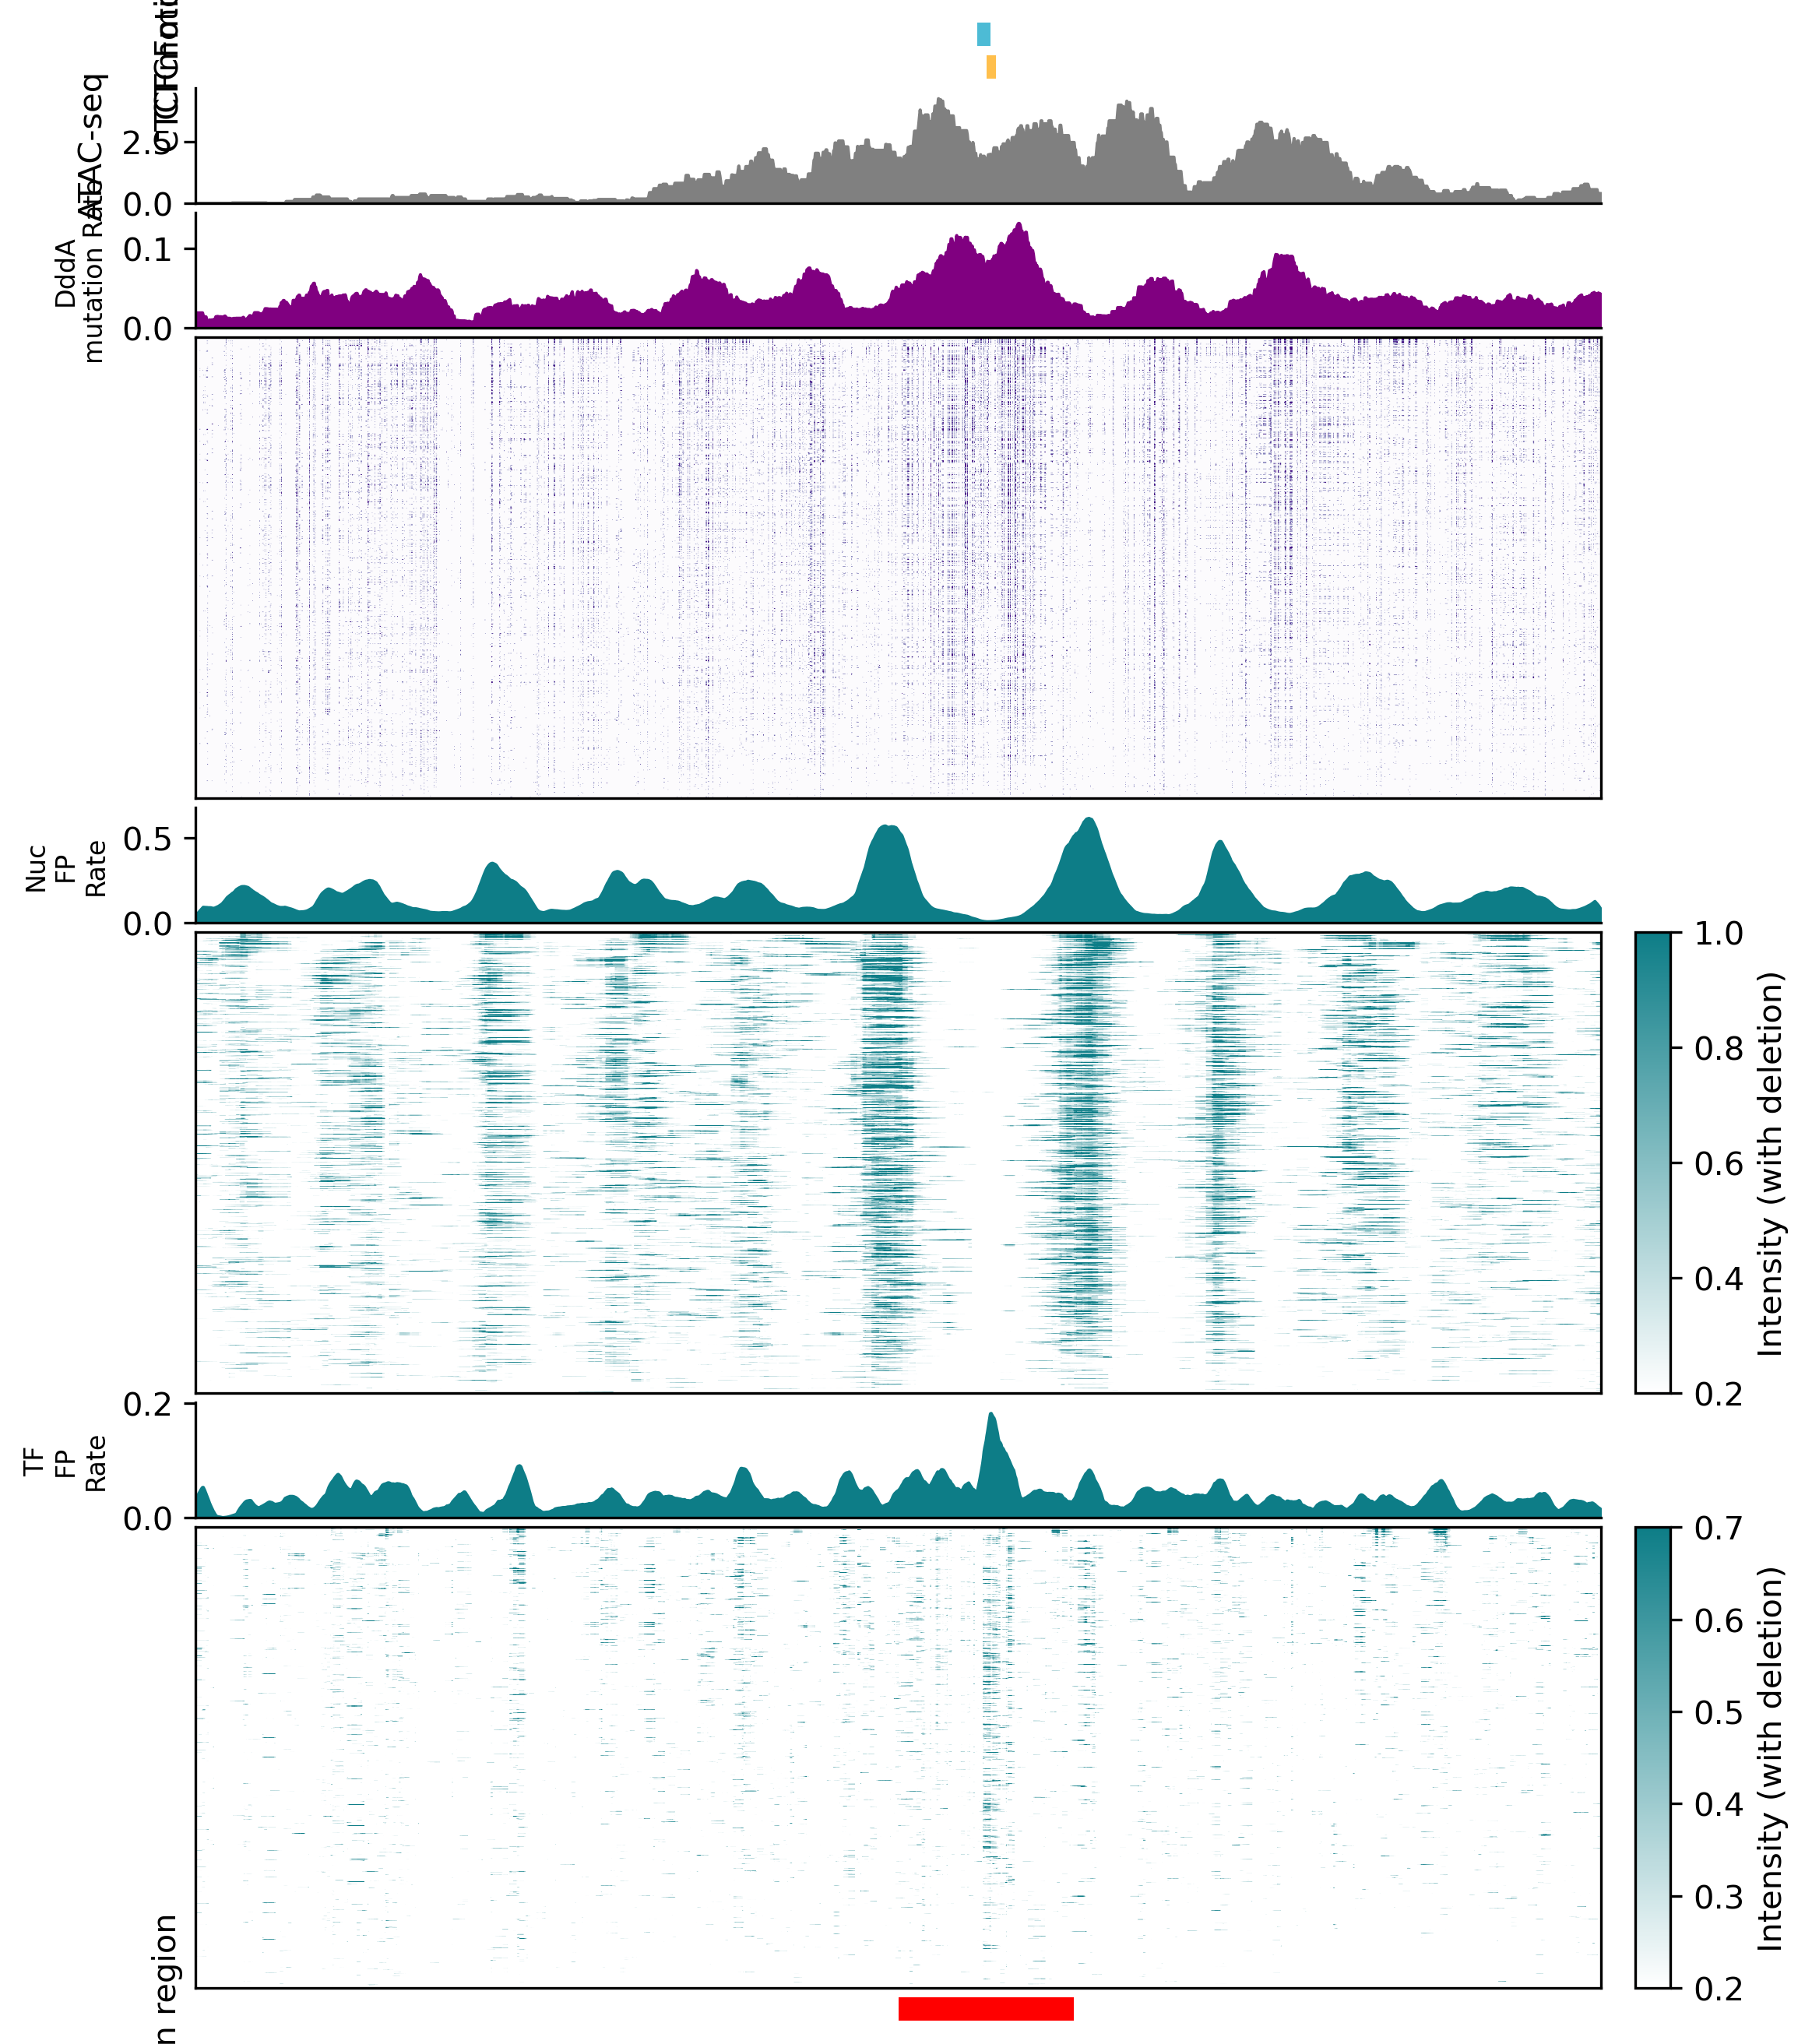

In [16]:
dark_green_cmap = LinearSegmentedColormap.from_list('dark_green', ['#FFFFFF', '#0d7d87'])
plot_range = np.arange(1500, 3500)
fig = plt.figure(dpi=300,figsize=(8, 8.853))
gs = GridSpec(10, 2, width_ratios=[20, 0.5], height_ratios=[0.1,0.1,0.5,0.5,2,0.5,2,0.5,2,0.1])

# Calculate average editing rate for each condition
track_deleted = np.mean(edits[np.array(selected_del_flags) == 1, :], axis=0)
track_undeleted = np.mean(edits[np.array(selected_del_flags) == 0, :], axis=0)

# Smooth tracks
track_deleted = np.convolve(track_deleted, np.ones(50), mode='same') / 50
track_undeleted = np.convolve(track_undeleted, np.ones(50), mode='same') / 50
track_deleted = track_deleted[plot_range]
track_undeleted = track_undeleted[plot_range]

ax5 = fig.add_subplot(gs[0, 0])
ax5.bar(CTCF_x_values_region, CTCF_values_region, color='#4dbbd5', alpha=1, width=1.0)
ax5.set_xlim([CTCF_x_values_region.min(), CTCF_x_values_region.max()])
ax5.set_ylim([0, 3])  # Set y-axis limits for the bar plot
ax5.set_xticks([])  # Remove x-axis ticks for the bar plot
ax5.set_yticks([])  # Remove y-axis ticks for the bar plot
ax5.set_ylabel('CTCFmotif')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.spines['left'].set_visible(False)

ax5 = fig.add_subplot(gs[1, 0])
ax5.bar(YY1_x_values_region, YY1_values_region, color='orange', alpha=0.7, width=1.0)
ax5.set_xlim([YY1_x_values_region.min(), YY1_x_values_region.max()])
ax5.set_ylim([0, 3])  # Set y-axis limits for the bar plot
ax5.set_xticks([])  # Remove x-axis ticks for the bar plot
ax5.set_yticks([])  # Remove y-axis ticks for the bar plot
ax5.set_ylabel('CTCFmotif')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.spines['left'].set_visible(False)

# New plot (Top plot)
ax2 = plt.subplot(gs[2,0])
ax2.fill_between(ATAC_x_values_plot, ATAC_y_values_convolve_plot, color='Grey', alpha=1)
ax2.set_xlim([ATAC_x_values_plot.min(), ATAC_x_values_plot.max()])
ax2.set_ylim([0, max(ATAC_y_values_convolve_plot) * 1.1])
ax2.set_xticks([])  # Remove x-axis ticks
ax2.set_xlabel('')
ax2.set_ylabel('ATAC-seq')

# Remove box outline and keep x and y axis
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax0 = plt.subplot(gs[3,0])
x_values = np.arange(len(track_undeleted))
ax0.fill_between(x_values, track_undeleted, color='purple', alpha=1)
ax0.set_xlim([x_values.min(), x_values.max()])
ax0.set_ylim([0, max(track_undeleted) * 1.1])
ax0.set_xticks([])  # Remove x-axis ticks
ax0.set_xlabel('')
ax0.set_ylabel('DddA\nmutation Rate', fontsize=8)

# Remove box outline and keep x and y axis
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)


# Order reads by edit number
edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())
read_edit_num = np.sum(edits, axis=1)

# Plot footprints of reads with deletion
undel_filter = np.where(selected_del_flags == 0)[0]
row_order = [i for i in np.argsort(-read_edit_num) if i in undel_filter]
ax1 = fig.add_subplot(gs[4, 0])
ax1.imshow(edits[row_order, :][:, plot_range], aspect='auto', vmax=1, vmin=0, cmap="Purples")
ax1.tick_params(left=False, bottom=False)
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])
ax1.spines['top'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

# Plot average footprints across single reads
smooth_radius = 20

# Compute average footprints for reads with CRISPR deletions at the target site
track_deleted = np.mean(fp_nuc[selected_del_flags == 1, :][:, plot_range], axis=0)
track_deleted = np.convolve(track_deleted, np.ones(smooth_radius), mode="same") / smooth_radius

# Compute average footprints for reads without CRISPR deletions at the target site
track_undeleted = np.mean(fp_nuc[selected_del_flags == 0, :][:, plot_range], axis=0)
track_undeleted = np.convolve(track_undeleted, np.ones(smooth_radius), mode="same") / smooth_radius

ax2 = plt.subplot(gs[5,0])
x_values = np.arange(len(track_undeleted))
ax2.fill_between(x_values, track_undeleted, color='#0d7d87', alpha=1)
ax2.set_xlim([x_values.min(), x_values.max()])
ax2.set_ylim([0, max(track_undeleted) * 1.1])
ax2.set_xticks([])  # Remove x-axis ticks
ax2.set_xlabel('')
ax2.set_ylabel('Nuc\nFP\nRate', fontsize=8)

# Remove box outline and keep x and y axis
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


# Plot footprints of reads with deletion
ax3 = fig.add_subplot(gs[6, 0])
im3 = ax3.imshow(fp_nuc[row_order, :][:, plot_range], aspect='auto', vmax=1, vmin=0.2, cmap=dark_green_cmap)
ax3.tick_params(left=False, bottom=False)
ax3.xaxis.set_ticklabels([])
ax3.yaxis.set_ticklabels([])
ax3.spines['top'].set_visible(True)
ax3.spines['right'].set_visible(True)
ax3.spines['bottom'].set_visible(True)
ax3.spines['left'].set_visible(True)

# Create a separate axis for the colorbar for ax3
cbar3 = fig.add_subplot(gs[6, 1])
fig.colorbar(im3, cax=cbar3)
cbar3.set_ylabel('Intensity (with deletion)')

# Compute average footprints for reads with CRISPR deletions at the target site
track_deleted = np.mean(fp_tf[selected_del_flags == 1, :][:, plot_range], axis=0)
track_deleted = np.convolve(track_deleted, np.ones(smooth_radius), mode="same") / smooth_radius

# Compute average footprints for reads without CRISPR deletions at the target site
track_undeleted = np.mean(fp_tf[selected_del_flags == 0, :][:, plot_range], axis=0)
track_undeleted = np.convolve(track_undeleted, np.ones(smooth_radius), mode="same") / smooth_radius

ax4 = plt.subplot(gs[7,0])
x_values = np.arange(len(track_undeleted))
ax4.fill_between(x_values, track_undeleted, color='#0d7d87', alpha=1)
ax4.set_xlim([x_values.min(), x_values.max()])
ax4.set_ylim([0, max(track_undeleted) * 1.1])
ax4.set_xticks([])  # Remove x-axis ticks
ax4.set_xlabel('')
ax4.set_ylabel('TF\nFP\nRate', fontsize=8)

# Remove box outline and keep x and y axis
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

ax5 = fig.add_subplot(gs[8, 0])
im5 = ax5.imshow(fp_tf[row_order, :][:, plot_range], aspect='auto', vmax=0.7, vmin=0.2, cmap=dark_green_cmap)
ax5.tick_params(left=False, bottom=False)
ax5.xaxis.set_ticklabels([])
ax5.yaxis.set_ticklabels([])
ax5.spines['top'].set_visible(True)
ax5.spines['right'].set_visible(True)
ax5.spines['bottom'].set_visible(True)
ax5.spines['left'].set_visible(True)

# Create a separate axis for the colorbar for ax3
cbar5 = fig.add_subplot(gs[8, 1])
fig.colorbar(im5, cax=cbar5)
cbar5.set_ylabel('Intensity (with deletion)')

ax5 = fig.add_subplot(gs[9, 0])
ax5.bar(open_x_values_region, open_values_region, color='red', alpha=1, width=1.0)
ax5.set_xlim([open_x_values_region.min(), open_x_values_region.max()])
ax5.set_ylim([0, 3])  # Set y-axis limits for the bar plot
ax5.set_xticks([])  # Remove x-axis ticks for the bar plot
ax5.set_yticks([])  # Remove y-axis ticks for the bar plot
ax5.set_ylabel('open region')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.spines['left'].set_visible(False)

# Adjust layout to make sure plots don't overlap
plt.tight_layout()
plt.subplots_adjust(hspace=0.05, right=0.9) 
# Save the combined figure
plt.savefig(os.path.join(plot_dir, "HJR235_undeleted_2623-2645_YY1_openregion.pdf"))
plt.show()

In [17]:
#sgRNA barplot
data_x_values = np.arange(ref_range_dict[locus][1], ref_range_dict[locus][2]+1)
bar_values = np.zeros_like(data_x_values)
bar_values[(data_x_values >= 27161138) & (data_x_values < 27161157)] = 3  # Adjust indices as needed
bar_values_region=bar_values[plot_range]
data_x_values_region=data_x_values[plot_range]

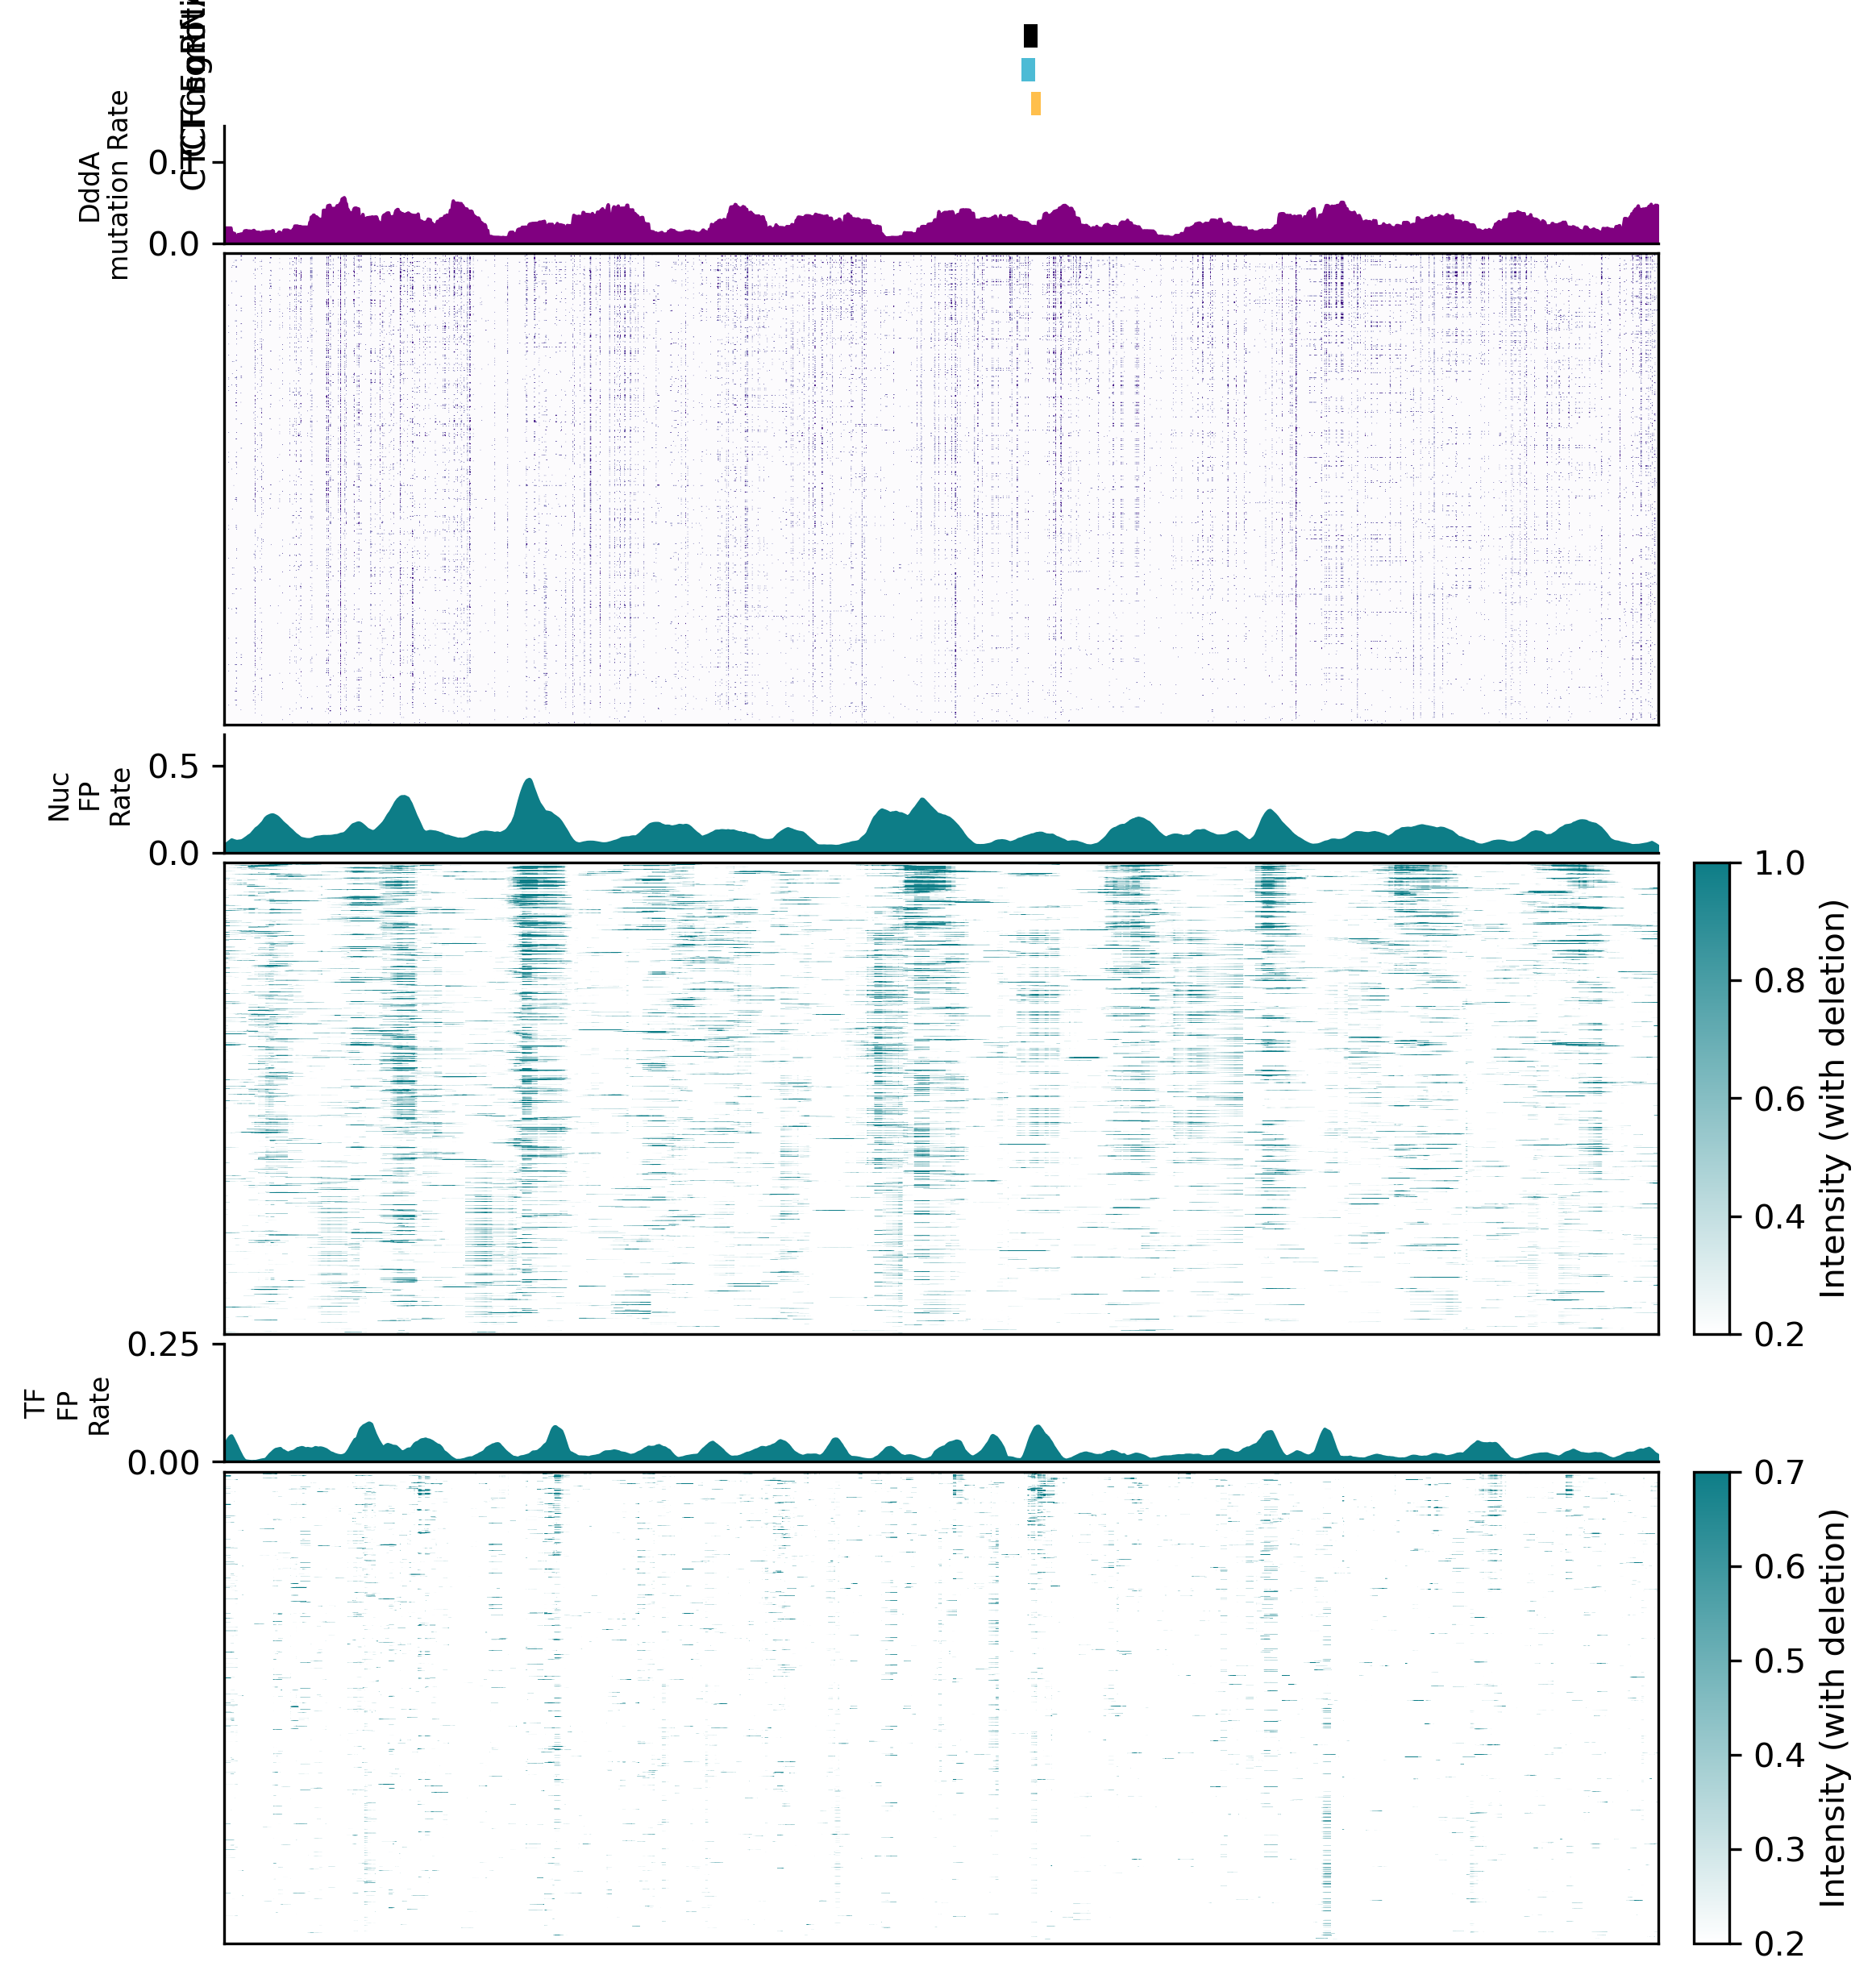

In [18]:
plot_range = np.arange(1500, 3500)
fig = plt.figure(dpi=300,figsize=(8, 8.317))
gs = GridSpec(9, 2, width_ratios=[20, 0.5], height_ratios=[0.1,0.1, 0.1, 0.5,2,0.5,2,0.5,2])

ax4 = fig.add_subplot(gs[0, 0])
ax4.bar(data_x_values_region, bar_values_region, color='black', alpha=1, width=1.0)
ax4.set_xlim([data_x_values_region.min(), data_x_values_region.max()])
ax4.set_ylim([0, 3])  # Set y-axis limits for the bar plot
ax4.set_xticks([])  # Remove x-axis ticks for the bar plot
ax4.set_yticks([])  # Remove y-axis ticks for the bar plot
ax4.set_ylabel('sgRNA')
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.spines['left'].set_visible(False)

ax5 = fig.add_subplot(gs[1, 0])
ax5.bar(CTCF_x_values_region, CTCF_values_region, color='#4dbbd5', alpha=1, width=1.0)
ax5.set_xlim([CTCF_x_values_region.min(), CTCF_x_values_region.max()])
ax5.set_ylim([0, 3])  # Set y-axis limits for the bar plot
ax5.set_xticks([])  # Remove x-axis ticks for the bar plot
ax5.set_yticks([])  # Remove y-axis ticks for the bar plot
ax5.set_ylabel('CTCFmotif')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.spines['left'].set_visible(False)

ax5 = fig.add_subplot(gs[2, 0])
ax5.bar(YY1_x_values_region, YY1_values_region, color='orange', alpha=0.7, width=1.0)
ax5.set_xlim([YY1_x_values_region.min(), YY1_x_values_region.max()])
ax5.set_ylim([0, 3])  # Set y-axis limits for the bar plot
ax5.set_xticks([])  # Remove x-axis ticks for the bar plot
ax5.set_yticks([])  # Remove y-axis ticks for the bar plot
ax5.set_ylabel('CTCFmotif')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.spines['left'].set_visible(False)


# Calculate average editing rate for each condition
track_deleted = np.mean(edits[np.array(selected_del_flags) == 1, :], axis=0)
track_undeleted = np.mean(edits[np.array(selected_del_flags) == 0, :], axis=0)

# Smooth tracks
track_deleted = np.convolve(track_deleted, np.ones(50), mode='same') / 50
track_undeleted = np.convolve(track_undeleted, np.ones(50), mode='same') / 50
track_deleted = track_deleted[plot_range]
track_undeleted = track_undeleted[plot_range]

ax0 = plt.subplot(gs[3,0])
x_values = np.arange(len(track_deleted))
ax0.fill_between(x_values, track_deleted, color='purple', alpha=1)
ax0.set_xlim([x_values.min(), x_values.max()])
ax0.set_ylim([0, max(track_undeleted) * 1.1])
ax0.set_xticks([])  # Remove x-axis ticks
ax0.set_xlabel('')
ax0.set_ylabel('DddA\nmutation Rate', fontsize=8)

# Remove box outline and keep x and y axis
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)


# Order reads by edit number
edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())
read_edit_num = np.sum(edits, axis=1)

# Plot footprints of reads with deletion
undel_filter = np.where(selected_del_flags == 1)[0]
row_order = [i for i in np.argsort(-read_edit_num) if i in undel_filter]
ax1 = fig.add_subplot(gs[4, 0])
ax1.imshow(edits[row_order, :][:, plot_range], aspect='auto', vmax=1, vmin=0, cmap="Purples")
ax1.tick_params(left=False, bottom=False)
ax1.xaxis.set_ticklabels([])
ax1.yaxis.set_ticklabels([])
ax1.spines['top'].set_visible(True)
ax1.spines['right'].set_visible(True)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

# Plot average footprints across single reads
smooth_radius = 20

# Compute average footprints for reads with CRISPR deletions at the target site
track_deleted = np.mean(fp_nuc[selected_del_flags == 1, :][:, plot_range], axis=0)
track_deleted = np.convolve(track_deleted, np.ones(smooth_radius), mode="same") / smooth_radius

# Compute average footprints for reads without CRISPR deletions at the target site
track_undeleted = np.mean(fp_nuc[selected_del_flags == 0, :][:, plot_range], axis=0)
track_undeleted = np.convolve(track_undeleted, np.ones(smooth_radius), mode="same") / smooth_radius

ax2 = plt.subplot(gs[5,0])
x_values = np.arange(len(track_deleted))
ax2.fill_between(x_values, track_deleted, color='#0d7d87', alpha=1)
ax2.set_xlim([x_values.min(), x_values.max()])
ax2.set_ylim([0, max(track_undeleted) * 1.1])
ax2.set_xticks([])  # Remove x-axis ticks
ax2.set_xlabel('')
ax2.set_ylabel('Nuc\nFP\nRate', fontsize=8)

# Remove box outline and keep x and y axis
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


# Plot footprints of reads with deletion
ax3 = fig.add_subplot(gs[6, 0])
im3 = ax3.imshow(fp_nuc[row_order, :][:, plot_range], aspect='auto', vmax=1, vmin=0.2, cmap=dark_green_cmap)
ax3.tick_params(left=False, bottom=False)
ax3.xaxis.set_ticklabels([])
ax3.yaxis.set_ticklabels([])
ax3.spines['top'].set_visible(True)
ax3.spines['right'].set_visible(True)
ax3.spines['bottom'].set_visible(True)
ax3.spines['left'].set_visible(True)

# Create a separate axis for the colorbar for ax3
cbar3 = fig.add_subplot(gs[6, 1])
fig.colorbar(im3, cax=cbar3)
cbar3.set_ylabel('Intensity (with deletion)')

# Compute average footprints for reads with CRISPR deletions at the target site
track_deleted = np.mean(fp_tf[selected_del_flags == 1, :][:, plot_range], axis=0)
track_deleted = np.convolve(track_deleted, np.ones(smooth_radius), mode="same") / smooth_radius

# Compute average footprints for reads without CRISPR deletions at the target site
track_undeleted = np.mean(fp_tf[selected_del_flags == 0, :][:, plot_range], axis=0)
track_undeleted = np.convolve(track_undeleted, np.ones(smooth_radius), mode="same") / smooth_radius

ax4 = plt.subplot(gs[7,0])
x_values = np.arange(len(track_deleted))
ax4.fill_between(x_values, track_deleted, color='#0d7d87', alpha=1)
ax4.set_xlim([x_values.min(), x_values.max()])
ax4.set_ylim([0, 0.25])
ax4.set_xticks([])  # Remove x-axis ticks
ax4.set_xlabel('')
ax4.set_ylabel('TF\nFP\nRate', fontsize=8)

# Remove box outline and keep x and y axis
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

ax5 = fig.add_subplot(gs[8, 0])
im5 = ax5.imshow(fp_tf[row_order, :][:, plot_range], aspect='auto', vmax=0.7, vmin=0.2, cmap=dark_green_cmap)
ax5.tick_params(left=False, bottom=False)
ax5.xaxis.set_ticklabels([])
ax5.yaxis.set_ticklabels([])
ax5.spines['top'].set_visible(True)
ax5.spines['right'].set_visible(True)
ax5.spines['bottom'].set_visible(True)
ax5.spines['left'].set_visible(True)

# Create a separate axis for the colorbar for ax3
cbar5 = fig.add_subplot(gs[8, 1])
fig.colorbar(im5, cax=cbar5)
cbar5.set_ylabel('Intensity (with deletion)')

# Adjust layout to make sure plots don't overlap
plt.tight_layout()
plt.subplots_adjust(hspace=0.05, right=0.9) 
# Save the combined figure
plt.savefig(os.path.join(plot_dir, "HJR235_deleted_2623-2645_YY1.pdf"))
plt.show()

### Calculate nucleosome footprint size distribution

In [19]:
# Calculate nucleosome footprints for individual reads
sample_read_inds = np.random.choice(undel_read_inds, 1000)
sample_dict = {"HJR235":np.array(ddda_data.read_ids[locus])[sample_read_inds]}
sample_edits = np.array(ddda_data.edit_dict[locus][sample_read_inds, :].todense())
sample_strands = ddda_data.read_strands[locus][sample_read_inds]
footprints_dict = ddda_data.get_footprints(
    sample_dict, 
    footprint_radii = np.arange(2, 100), 
    combine_sides="max_pval")

# Convert to -log10 pval
fp_nuc = np.squeeze(np.array([i for i in footprints_dict[locus].values()]))
fp_nuc = -np.log10(fp_nuc)

Computing footprints for HJR235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:33<00:00,  4.68it/s]


<Axes: >

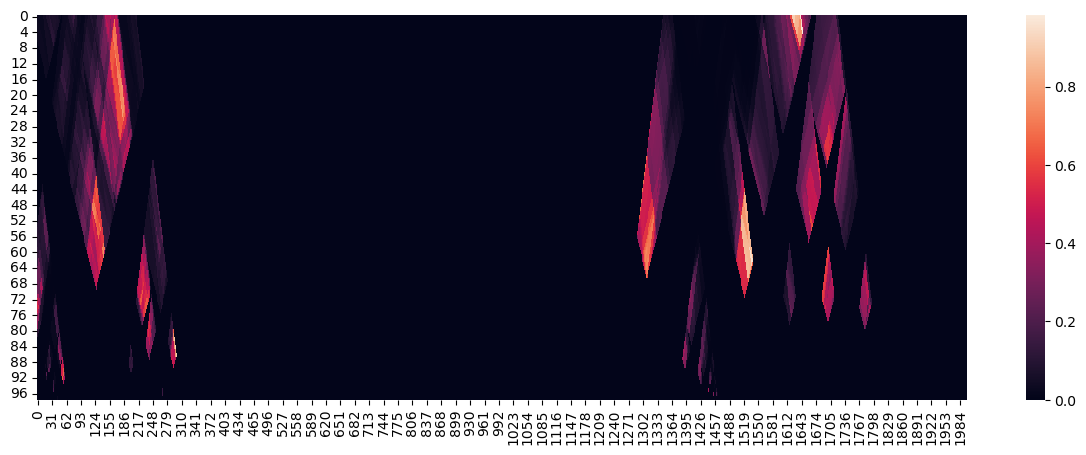

In [20]:
plt.figure(figsize=(15,5))
sns.heatmap(np.flip(fp_nuc[0, :, 500:2500]))

For each single read, we detect nucleosome summit positions, and retrieve DddA edits from a +/-200bp window around the summits

In [21]:
nuc_window_edits = []
nuc_window_bias = []
max_signal_scale = []
window_radius = 200
for read_ind in range(fp_nuc.shape[0]):
    max_proj = np.max(fp_nuc[read_ind, :, :], axis=0)
    max_proj = np.convolve(max_proj, np.ones(20), mode="same")/20
    region_len = len(max_proj)
    signal_threshold = 1
    nuc_calling_r = 50
    nuc_centers = []
    for i in range(window_radius, region_len - window_radius):
        local_signal = max_proj[(i - nuc_calling_r):(i + nuc_calling_r)]
        center_signal = max_proj[i]
        if center_signal == np.max(local_signal) and center_signal > signal_threshold:
            nuc_centers.append(i)
            local_edits = sample_edits[read_ind, (i - window_radius):(i + window_radius)]
            nuc_window_edits.append(local_edits)
            nuc_window_bias.append(
                ddda_data.bias_dict[locus][ (i - window_radius):(i + window_radius), 
                sample_strands[read_ind]]
            )
            max_signal_scale.append(np.argmax(fp_nuc[read_ind, :, i]))
nuc_window_edits_smoothed = np.array([np.convolve(i, np.ones(50), mode="same")/50 for i in nuc_window_edits])
nuc_window_edits = np.array(nuc_window_edits)
nuc_window_bias = np.array(nuc_window_bias)
max_signal_scale = np.array(max_signal_scale)

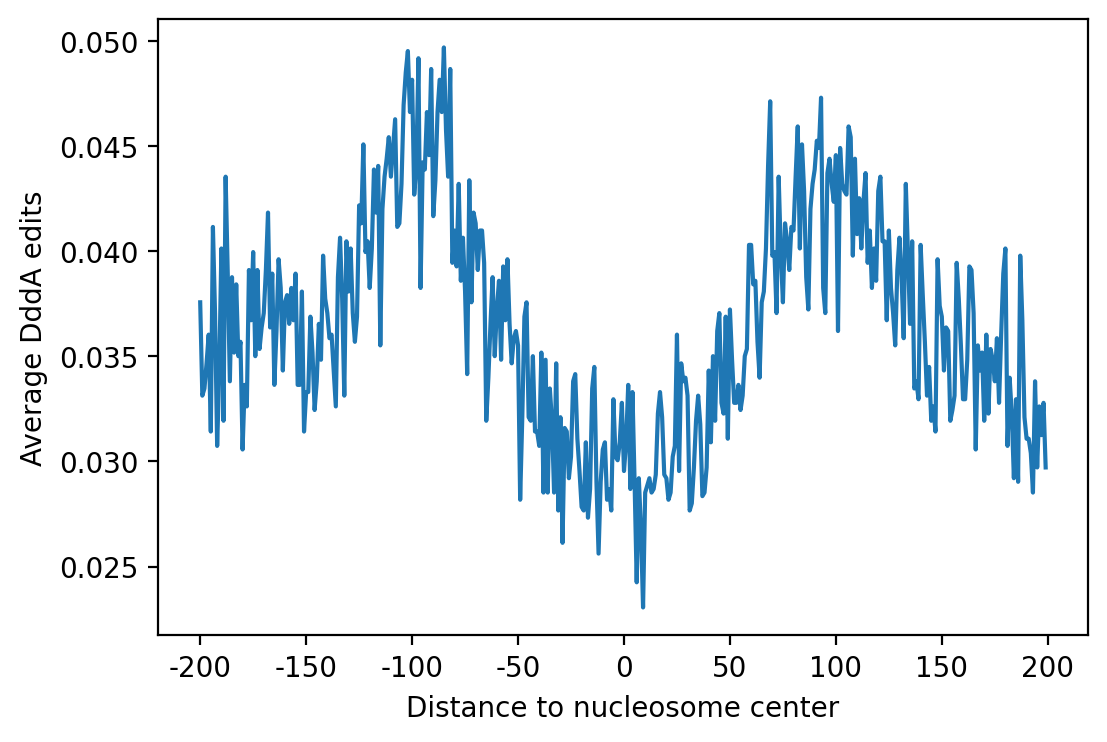

In [22]:
fig, ax = plt.subplots(dpi=200, figsize=(6,4))
plt.plot(np.mean(nuc_window_edits, axis=0))
plt.xticks(np.arange(0, 401, 50))
ax.set_xticklabels(np.arange(-200, 201, 50))
plt.xlabel("Distance to nucleosome center")
plt.ylabel("Average DddA edits")
plt.savefig(os.path.join(plot_dir, "HJR235_avg_nuc_edits.pdf"))
plt.show()

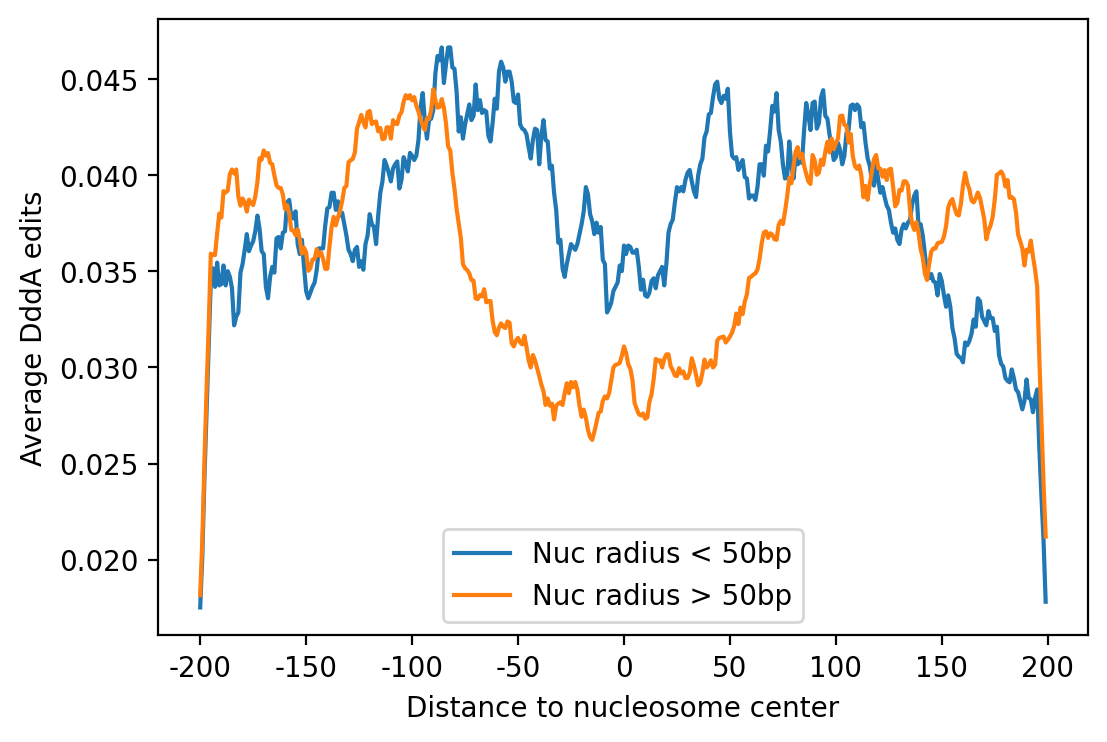

In [23]:
narrow_nuc_edits = np.mean(nuc_window_edits[max_signal_scale < 50, :], axis=0)
wide_nuc_edits = np.mean(nuc_window_edits[max_signal_scale > 60, :], axis=0)
smooth_radius = 10
narrow_nuc_edits = np.convolve(narrow_nuc_edits, np.ones(smooth_radius), mode="same") / smooth_radius
wide_nuc_edits = np.convolve(wide_nuc_edits, np.ones(smooth_radius), mode="same") / smooth_radius

fig, ax = plt.subplots(dpi=200, figsize=(6,4))
plt.plot(narrow_nuc_edits, label="Nuc radius < 50bp")
plt.plot(wide_nuc_edits, label="Nuc radius > 50bp")
plt.xticks(np.arange(0, 401, 50))
ax.set_xticklabels(np.arange(-200, 201, 50))
plt.xlabel("Distance to nucleosome center")
plt.ylabel("Average DddA edits")
plt.legend()
plt.savefig(os.path.join(plot_dir, "HJR235_avg_nuc_edits_stratified.pdf"))
plt.show()